In [1]:
import numpy as np
import os
import xarray as xr
from matplotlib import pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp2d
import scipy.optimize as so
import math

1. Import data
   path_nadir and path_SWOTpass on OSMOSIS1 domain are imported:

In [2]:
#### SWOT DATA
# Make sure to put this script in the directory below (/data/OSMOSIS/) before you run it

domain_name = 'OSMOSIS1'
#addpath = '/home/hafolahbi/Desktop/INTERN/Work/SWOT_prac/data'
#os.chdir(r'/home/hafolahbi/Desktop/INTERN/Work/SWOT_prac/data/OSMOSIS')

# Name of the SWOT pass in data/*domain*/ directory
if domain_name == 'OSMOSIS1' :
    path_SWOTpass = 'BOOST-SWOT_SWOT_OSMOSIS_c02_p436.nc'
    path_nadir = 'BOOST-SWOT_J1_nadir_c05_p01.nc'
    # Plotting params
    max_range = 0.2 # Limit for colorbar (SSH in meters) for SSH
    max_range_diff = 0.1 # Limit for colorbar (SSH in meters) for SSH differences

2. Then SWOT and Nadir paths are downloaded

In [3]:
#### Download the SWOT path

roll_error_only = True

all_but_karin = False

with xr.open_dataset(path_SWOTpass, mask_and_scale=True) as (ds_SWOTpass):
    ntime = ds_SWOTpass.time.size
#ds_SWOTpass.info() # Dimension of the dataset
    nc = ds_SWOTpass.nC.size
    lon_swotpass = np.zeros([ntime, nc])
    lon_swotpass [:,:] = ds_SWOTpass.lon
    lon_swotpass = np.ma.masked_invalid(lon_swotpass)
    lat_swotpass = np.zeros([ntime,nc])
    lat_swotpass [:,:] = ds_SWOTpass.lat
    lat_swotpass = np.ma.masked_invalid(lat_swotpass)
    ssh_swotpass = np.zeros([ntime,nc])
    if roll_error_only:
        ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err
    elif all_but_karin:
       ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err + ds_SWOTpass.phase_err + ds_SWOTpass.timing_err + ds_SWOTpass.bd_err
    else: 
        ssh_swotpass[:, :] = ds_SWOTpass.ssh_obs
    ssh_swotpass = np.ma.masked_invalid(ssh_swotpass)
    ssh_swotpass_truth = np.zeros([ntime, nc]) 
    ssh_swotpass_truth[:, :] = ds_SWOTpass.ssh_model # ssh model
    ssh_swotpass_truth = np.ma.masked_invalid(ssh_swotpass_truth)
    
# Swot and all errors with kaRIn
    ssh_swotpass_all_err = np.zeros([ntime,nc])
    ssh_swotpass_all_err[:,:] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err + ds_SWOTpass.phase_err + ds_SWOTpass.timing_err + ds_SWOTpass.bd_err + ds_SWOTpass.karin_err



In [4]:
#### Download the NADIR path
with xr.open_dataset(path_nadir, mask_and_scale=True) as ds_nadirpass:
    ndtime = ds_nadirpass.time.size
    lon_nadirpass = np.zeros([ndtime])
    lon_nadirpass[:] = ds_nadirpass.lon
    lat_nadirpass = np.zeros([ndtime])
    lat_nadirpass[:] = ds_nadirpass.lat
    x_al = np.zeros([ndtime])
    x_al[:] = ds_nadirpass.x_al
    ssh_nadir = np.zeros([ndtime])  

    ssh_nadir[:] = ds_nadirpass.ssh_obs
    ssh_nadir_truth = np.zeros([ndtime])  
    ssh_nadir_truth[:] = ds_nadirpass.ssh_model


3. SSH along nadir track (x_al) for Nadir data

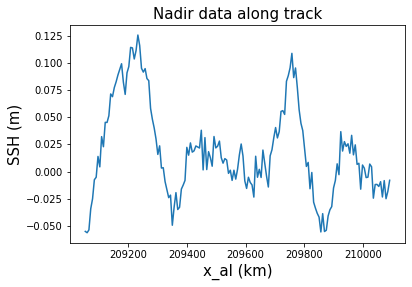

In [5]:
### SSH(m) vs Nadir along track (x_al) for Nadir data
plt.figure()
plt.plot(x_al,ssh_nadir)
plt.ylabel('SSH (m)',fontsize=15)
plt.xlabel('x_al (km)',fontsize=15)
plt.title('Nadir data along track', fontsize=15)
plt.show()

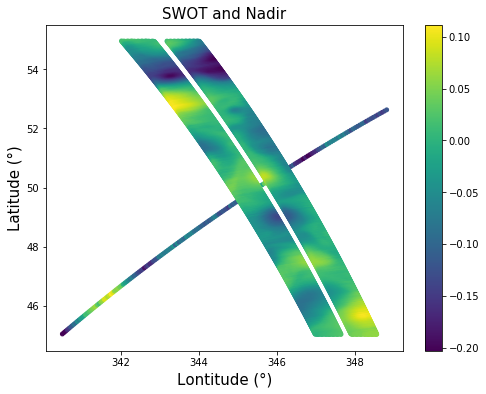

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(lon_nadirpass,lat_nadirpass,c=ssh_nadir,s=15) 
plt.scatter(lon_swotpass, lat_swotpass,c=ssh_swotpass,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT and Nadir',fontsize=15)
plt.colorbar()

# Interpolation of SWOT on Nadir

In [7]:
lon_swotcut = lon_swotpass[250:350]
lat_swotcut = lat_swotpass[250:350]
ssh_swotcut = ssh_swotpass[250:350]

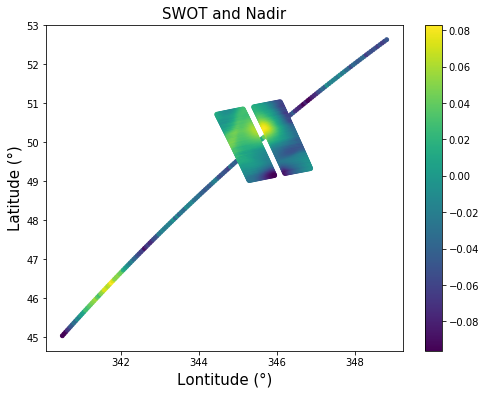

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(lon_nadirpass,lat_nadirpass,c=ssh_nadir,s=15) 
plt.scatter(lon_swotcut, lat_swotcut,c=ssh_swotcut,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT and Nadir',fontsize=15)
plt.colorbar() 

In [9]:

swot2nadir_interp = interp2d(lon_swotcut, lat_swotcut, ssh_swotcut)
swot2nadir_interp

/home/hafolahbi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=64,86 m=5200 fp=0.001106 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


# Nadir 

In [10]:
swot_on_nadir = swot2nadir_interp(lon_nadirpass, lat_nadirpass)
print(swot_on_nadir.shape)
swot_on_nadir =np.diag(swot_on_nadir)

(169, 169)


In [11]:
#swot_on_nadir = swot_on_nadir[swot_on_nadir!=0]
#lon_nadirpass_cut = lon_nadirpass[swot_on_nadir!=0]
#lat_nadirpass_cut = lat_nadirpass[swot_on_nadir!=0]

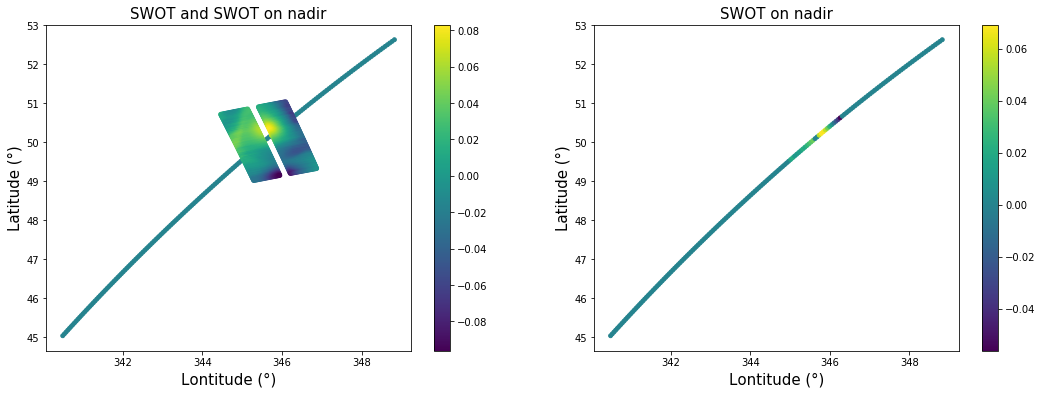

In [12]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.scatter(lon_nadirpass,lat_nadirpass,c=swot_on_nadir,s=15) 
plt.scatter(lon_swotcut, lat_swotcut,c=ssh_swotcut,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT and SWOT on nadir',fontsize=15)
plt.colorbar()
plt.subplot(122)
plt.scatter(lon_nadirpass,lat_nadirpass,c=swot_on_nadir,s=15) 
#plt.scatter(lon_swotcut, lat_swotcut,c=ssh_swotcut,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT on nadir',fontsize=15)
plt.colorbar()

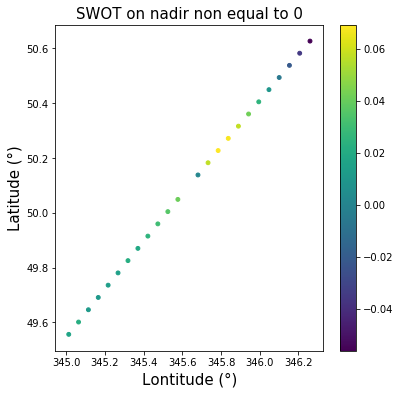

In [13]:
plt.figure(figsize=(6,6)) 
plt.scatter(lon_nadirpass,lat_nadirpass,c=np.ma.masked_where(swot_on_nadir==0,swot_on_nadir),s=15) 
#plt.scatter(lon_swotcut, lat_swotcut,c=ssh_swotcut,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT on nadir non equal to 0',fontsize=15)
plt.colorbar()

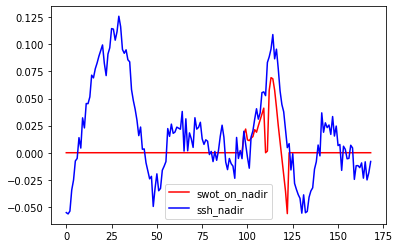

In [14]:
plt.plot(swot_on_nadir,color='r',label='swot_on_nadir')
plt.plot(ssh_nadir,color='b',label='ssh_nadir')
plt.legend()

In [15]:
swot_on_nadir_cut = swot_on_nadir[swot_on_nadir!=0]
ssh_nadir_cut = ssh_nadir[swot_on_nadir!=0] 

In [16]:
ssh_nadir.shape

(169,)

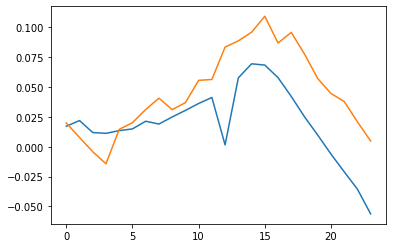

In [17]:
plt.plot(swot_on_nadir_cut)
plt.plot(ssh_nadir_cut)

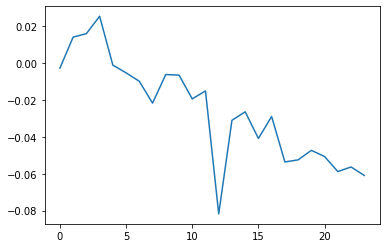

In [18]:
plt.plot(swot_on_nadir_cut-ssh_nadir_cut)

In [19]:
#ls -l

In [20]:
### We can now start the interpolation on the new ssh_nadir

from function_nadirpoints_in_swotgrid import nadirpoints_in_swotgrid

ssh_nadir_cut= nadirpoints_in_swotgrid(lon_nadirpass, lat_nadirpass, ssh_nadir, lon_swotcut, lat_swotcut)
swot_on_nadir = nadirpoints_in_swotgrid(lon_nadirpass, lat_nadirpass, swot_on_nadir, lon_swotcut, lat_swotcut)

In [21]:
### We can now start the interpolation on the new ssh_nadir

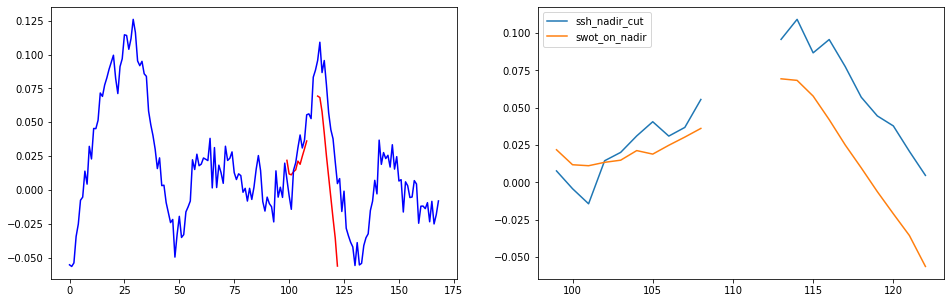

In [22]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(swot_on_nadir,color='r')
plt.plot(ssh_nadir,color='b')
plt.subplot(122)
plt.plot(ssh_nadir_cut,label='ssh_nadir_cut')
plt.plot(swot_on_nadir,label='swot_on_nadir')
plt.legend()

In [23]:
# Difference (C(h) as used in the Latex document) between the ssh (swot_on_nadir) and the ssh nadir
Difference = swot_on_nadir-ssh_nadir_cut
#Difference

# To interpolate error free SWOT onto Nadir

In [24]:
ssh_swottruthcut = ssh_swotpass_truth[250:350]
swot_on_nadir_func = interp2d(lon_swotcut,lat_swotcut,ssh_swottruthcut)

/home/hafolahbi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=72,77 m=5200 fp=0.000010 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


Text(0, 0.5, 'SSH (m)')

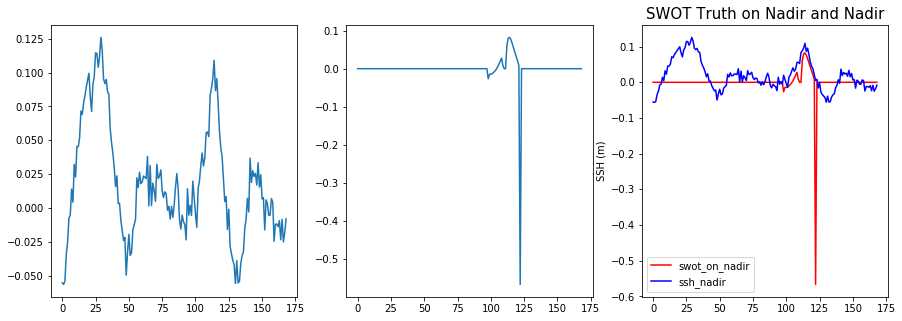

In [25]:
swottruth_on_nadir = swot_on_nadir_func(lon_nadirpass,lat_nadirpass)
swottruth_on_nadir = np.diag(swottruth_on_nadir)
swottruth_on_nadir.shape # SWOT SSH on Nadir

# To plot
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(ssh_nadir)
plt.subplot(132)
plt.plot(swottruth_on_nadir)
plt.subplot(133)
plt.plot(swottruth_on_nadir,label='swot_on_nadir',color='r')
plt.plot(ssh_nadir,label='ssh_nadir',color='b')
plt.legend()
plt.title('SWOT Truth on Nadir and Nadir',fontsize=15)
plt.ylabel('SSH (m)')

In [26]:
#ls -l

In [27]:
import function_nadirpoints_in_swotgrid
#help(function_nadirpoints_in_swotgrid)
from function_nadirpoints_in_swotgrid import nadirpoints_in_swotgrid

Text(0, 0.5, 'SSH (m)')

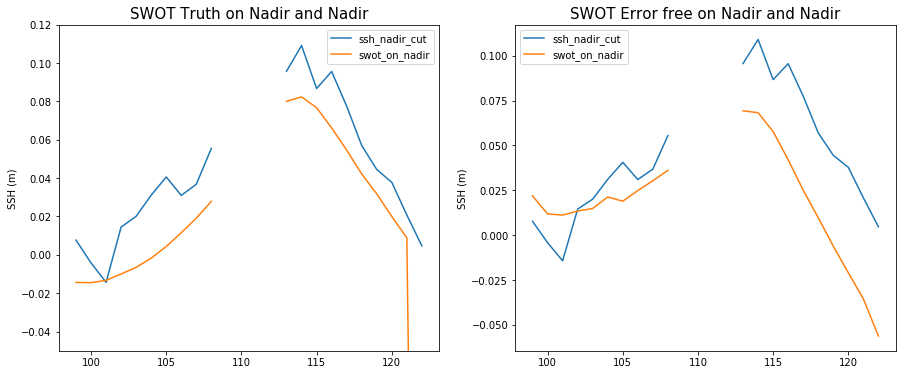

In [28]:
ssh_nadir = nadirpoints_in_swotgrid(lon_nadirpass, lat_nadirpass, ssh_nadir, lon_swotcut, lat_swotcut)
ssh_swottruth =  nadirpoints_in_swotgrid(lon_nadirpass, lat_nadirpass,swottruth_on_nadir, lon_swotcut, lat_swotcut)
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(ssh_nadir,label='ssh_nadir_cut')
plt.plot(ssh_swottruth,label='swot_on_nadir')
plt.legend()
plt.title('SWOT Truth on Nadir and Nadir',fontsize=15)
plt.ylabel('SSH (m)')
x = plt.gca()
x.set_ylim(-0.05,0.12)
plt.subplot(122)
plt.plot(ssh_nadir_cut,label='ssh_nadir_cut')
plt.plot(swot_on_nadir,label='swot_on_nadir')
plt.legend()
plt.title('SWOT Error free on Nadir and Nadir',fontsize=15)
plt.ylabel('SSH (m)')



#################################
# We can see below that the difference between swot_on_nadir and nadir in the first figure(right side of plot)
# is smaller than in the right figure
#### This is because the SWOT in the right figure has more errors than in the left figure







################################

# Cost Fuction

In [29]:
#from Lateef_cost_function import cost_function
#(cost_function(ssh_swotpass, swot_on_nadir, ssh_nadir_cut)

In [30]:
#cost_function(ssh_swotpass, swot_on_nadir, ssh_nadir_cut)

def cost_function(ssh_swotpass, swot_on_nadir, ssh_nadir_cut):
    n_gap=10
    ssh_swotgrid0 = ssh_swotpass
    ssh_across = np.nanmean(ssh_swotgrid0,0)
    dimtime = np.shape(ssh_swotgrid0)[0]
    # Width of the swath
    dimnc = np.shape(ssh_swotgrid0)[1]
    if np.shape(ssh_across)[0]==dimnc:
        nn = np.shape(ssh_across)[0]
        a1=0
        b1=0 
        c1=0 
        e11=0
        e12=0 
        f11=0
        f12=0 
        h = 0
    if nn != 0:
        x_across = np.arange(nn)-int(nn/2)    
        x_across[x_across<0]=x_across[x_across<0]-n_gap/2+1 
        x_across[x_across>=0]=x_across[x_across>=0]+n_gap/2  
        if nn == np.shape(x_across)[0]:
            # Cost function
            def linreg3(params): # params[7]== sought ssh==h 
                return np.sum(swot_on_nadir-ssh_nadir_cut)**2 + np.sum( 1/2*( params[7]-ssh_across+(params[0]+params[1]*x_across + params[2]*x_across**2 +np.append(params[3]+params[4]*x_across[x_across<=0],params[5]+params[6]*x_across[x_across>0],axis=0) ) )**2 ) 
            # Minimization  
            params = np.array([a1,b1,c1,e11,e12,f11,f12,h])
            coefopt = so.minimize(linreg3, params, method = "Powell") 
            a1,b1,c1,e11,e12,f11,f12,h = coefopt['x'][0], coefopt['x'][1], coefopt['x'][2], coefopt['x'][3], coefopt['x'][4], coefopt['x'][5], coefopt['x'][6] , coefopt['x'][7]
    return a1,b1,c1,e11,e12,f11,f12,h
   